In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.tsa.stattools import acf

sns.set_theme()

### Load Data

In [18]:
walmart = pd.read_csv('data/walmart.csv')
amazon = pd.read_csv('data/amazon.csv')

In [19]:
print(f'Walmart Cols: {list(walmart.columns)}')
print()
print(f'Amazon Cols: {list(amazon.columns)}')

Walmart Cols: ['Uniq Id', 'Crawl Timestamp', 'Product Url', 'Product Name', 'Description', 'List Price', 'Sale Price', 'Brand', 'Item Number', 'Gtin', 'Package Size', 'Category', 'Postal Code', 'Available']

Amazon Cols: ['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category', 'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Product Dimensions', 'Image', 'Variants', 'Sku', 'Product Url', 'Stock', 'Product Details', 'Dimensions', 'Color', 'Ingredients', 'Direction To Use', 'Is Amazon Seller', 'Size Quantity Variant', 'Product Description']


In [20]:
# select relevant columns
walmart = walmart[['Product Name', 'Sale Price', 'Brand', 'Category']]
amazon = amazon[['Product Name', 'Brand Name', 'Category', 'Selling Price']]

### Data Preprocessing

In [21]:
# extract primary category
extract_primary_category = lambda s: s.split(' | ')[0] if not pd.isna(s) else np.nan
walmart['Primary Category'] = walmart['Category'].apply(extract_primary_category)
amazon['Primary Category'] = amazon['Category'].apply(extract_primary_category)

walmart = walmart.drop(columns=['Category'])
amazon = amazon.drop(columns=['Category'])

In [22]:
# extract price
def extract_price(s):
    if pd.isna(s):
        return np.nan
    
    s = s.replace('$', '').replace(',', '')
    if ' - ' in s:
        s1, s2 = s.split(' - ')
        s = (float(s1) + float(s2)) / 2
        return s
    try:
        return float(s)
    except:
        return np.nan
    
amazon['Selling Price'] = amazon['Selling Price'].apply(extract_price)
amazon = amazon.drop(amazon[amazon['Selling Price'].isna()].index)

In [23]:
# category selection
walmart_categories_to_keep = ['Sports & Outdoors', 'Health', 'Household Essentials', 'Home', 'Baby', 'Toys', 'Home Improvement', 'Clothing', 'Jewelry']
amazon_categories_to_keep = ['Toys & Games', 'Home & Kitchen', 'Clothing, Shoes & Jewelry', 'Sports & Outdoors', 'Baby Products', 'Health & Household']

walmart = walmart[walmart['Primary Category'].isin(walmart_categories_to_keep)]
amazon = amazon[amazon['Primary Category'].isin(amazon_categories_to_keep)]

def universalize_walmart(category):
    if category in ['Health', 'Household Essentials', 'Home', 'Home Improvement']:
        return 'Health & Household'
    if category in ['Clothing', "Jewelry"]:
        return 'Clothing, Shoes & Jewelry'
    return category

def universalize_amazon(category):
    if category in ['Home & Kitchen', 'Health & Household']:
        return 'Health & Household'
    if category == 'Baby Products':
        return 'Baby'
    if category == 'Toys & Games':
        return 'Toys'
    return category

walmart['Universal Category'] = walmart['Primary Category'].apply(universalize_walmart)
amazon['Universal Category'] = amazon['Primary Category'].apply(universalize_amazon)

In [24]:
# outlier elimination
walmart_outlier_lims = {}
amazon_outlier_lims = {}

iqr_mult = 1.5
for cat in walmart['Universal Category'].unique():
    walmart_pr = (walmart[walmart['Universal Category'] == cat]['Sale Price'])
    amazon_pr = (amazon[amazon['Universal Category'] == cat]['Selling Price'])
    
    walmart_limit = walmart_pr.quantile(0.75) + (walmart_pr.quantile(0.75) - walmart_pr.quantile(0.25)) * iqr_mult
    amazon_limit = amazon_pr.quantile(0.75) + (amazon_pr.quantile(0.75) - amazon_pr.quantile(0.25)) * iqr_mult
    
    walmart_outlier_lims[cat] = walmart_limit
    amazon_outlier_lims[cat] = amazon_limit
    
    walmart_prop = walmart_pr > walmart_limit
    amazon_prop = amazon_pr > amazon_limit
    
    print()
    print(f'Walmart - {cat} < {walmart_limit.round(2)}: Prop = {walmart_prop.mean()}; Num = {walmart_prop.sum()}')
    print(f'Amazon - {cat} < {amazon_limit.round(2)}: Prop = {amazon_prop.mean()}, Num = {amazon_prop.sum()}')
    
walmart_outlier_indices = []
amazon_outlier_indices = []
for cat in walmart['Universal Category'].unique():
    walmart_cat = walmart[walmart['Universal Category'] == cat]
    amazon_cat = amazon[amazon['Universal Category'] == cat]
    
    walmart_outlier_indices += list(walmart_cat[walmart_cat['Sale Price'] > walmart_outlier_lims[cat]].index)
    amazon_outlier_indices += list(amazon_cat[amazon_cat['Selling Price'] > amazon_outlier_lims[cat]].index)
    

walmart = walmart.drop(walmart_outlier_indices)
amazon = amazon.drop(amazon_outlier_indices)


Walmart - Health & Household < 66.04: Prop = 0.0962962962962963; Num = 624
Amazon - Health & Household < 155.94: Prop = 0.1048158640226629, Num = 74

Walmart - Sports & Outdoors < 161.54: Prop = 0.11378872984236274; Num = 1256
Amazon - Sports & Outdoors < 224.39: Prop = 0.10144927536231885, Num = 49

Walmart - Baby < 89.96: Prop = 0.13217138707334786; Num = 364
Amazon - Baby < 63.26: Prop = 0.07109004739336493, Num = 15

Walmart - Clothing, Shoes & Jewelry < 102.14: Prop = 0.0881057268722467; Num = 40
Amazon - Clothing, Shoes & Jewelry < 62.55: Prop = 0.04952076677316294, Num = 31

Walmart - Toys < 243.27: Prop = 0.135632183908046; Num = 118
Amazon - Toys < 51.61: Prop = 0.10001536334306345, Num = 651


In [25]:
print(walmart.shape)
walmart.head()

(19194, 5)


,Product Name,Sale Price,Brand,Primary Category,Universal Category
1,Equate Triamcinolone Acetonide Nasal Allergy S...,10.48,Equate,Health,Health & Household
3,"24"" Classic Adjustable Balloon Fender Set Chro...",38.59,lowrider,Sports & Outdoors,Sports & Outdoors
4,Elephant Shape Silicone Drinkware Portable Sil...,5.81,Anself,Baby,Baby
6,"Toytainer Shoe Box Play-N-Store, Boy",11.52,Toytainer,Home,Health & Household
7,Dometic D1112002 D Line 3 N 1 Bowl Cleaner and...,34.41,Dometic,Household Essentials,Health & Household


In [26]:
print(amazon.shape)
amazon.head()

(7715, 5)


,Product Name,Brand Name,Selling Price,Primary Category,Universal Category
2,3Doodler Create Flexy 3D Printing Filament Ref...,NaN,34.99,Toys & Games,Toys
3,Guillow Airplane Design Studio with Travel Cas...,NaN,28.91,Toys & Games,Toys
4,Woodstock- Collage 500 pc Puzzle,NaN,17.49,Toys & Games,Toys
6,Rubie's Child's Pokemon Deluxe Pikachu Costume...,NaN,29.12,"Clothing, Shoes & Jewelry","Clothing, Shoes & Jewelry"
8,"ARTSCAPE Etched Glass 24"" x 36"" Window Film, 2...",NaN,12.99,Home & Kitchen,Health & Household


In [16]:
#walmart = walmart.drop(columns=['Brand'])
#amazon = amazon.drop(columns=['Brand Name'])

<br></br>
<br></br>
<br></br>

# Regression

In [31]:
# I wanted to edit the dataframes to match each other and also have the syntax work for the regression (I don't think it accepts spaces).
amazon_reg = amazon.rename(columns={'Brand Name':'brand', 'Selling Price':'sale_price', 'Primary Category':'primary_category', 'Universal Category':'universal_category'})
walmart_reg = walmart.rename(columns={'Brand':'brand', 'Sale Price':'sale_price', 'Primary Category':'primary_category', 'Universal Category':'universal_category'})

# combine data frames and label by store
amazon_reg['store'] = 'amazon'
walmart_reg['store'] = 'walmart'

df = pd.concat([amazon_reg, walmart_reg])[['brand', 'sale_price', 'primary_category', 'universal_category', 'store']]

In [34]:
df['store'].value_counts()

store
walmart    19194
amazon      7715
Name: count, dtype: int64

In [38]:
response = 'sale_price'
model_formula = f"{response} ~ {' + '.join(['store', 'universal_category'])}"
model = smf.ols(model_formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     497.0
Date:                Fri, 07 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:25:45   Log-Likelihood:            -1.2707e+05
No. Observations:               26909   AIC:                         2.542e+05
Df Residuals:                   26903   BIC:                         2.542e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          20.2029      0.769     26.289      0.000      18.697      21.709
store[T.walmart]                                    3.2792      0.597      5.494      0.000       2.109       4.449
universal_category[T.Clothing, Shoes & Jewelry]     5.8062      1.055      5.501      0.000       3.737       7.875
universal_category[T.Health & Household]           -1.9718      0.633     -3.116      0.002      -3.212      -0.731
universal_category[T.Sports & Outdoors]            15.0875      0.599     25.177      0.000      13.913      16.262
universal_category[T.Toys]                          0.1908      0.795      0.240      0.810      -1.368       1.749
==============================================================================
Omnibus:                    13306.745   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91172.776
Skew:                           2.308   Prob(JB):                         0.00
Kurtosis:                      10.747   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation of the coefficients

---
We see that all coefficients are significant at the $\alpha=0.05$ level aside from the Toys category. The reference category used in the case of the store and universal_category covariates is 'amazon' and 'baby'.

- store[T.walmart]: **Holding all else constant, a change from the reference category, 'amazon', to 'walmart' is predicted to increase the sales price by 3.2792 dollars**
- universal_category[T.Clothing, Shoes & Jewelry]: Holding all else constant, a change from the reference category, 'baby', to 'clothing, shoes & jewelry' is predicted to increase the sales price by 5.8062 dollars
- universal_category[T.Health & Household]: Holding all else constant, a change from the reference category, 'baby', to 'health & household' is predicted to decrease the sales price by 1.9718 dollars
- universal_category[T.Sports & Outdoors]: Holding all else constant, a change from the reference category, 'baby', to 'sports & outdoors' is predicted to increase the sales price by 0.1908 dollars

Let's perform an ANOVA test to see whether or not the inclusion of the 'store' variable signficantly improve the predictions output by this regression model.

In [76]:
small_formula = f"{response} ~ universal_category"
big_formula = f"{response} ~ {' + '.join(['store', 'universal_category'])}"

In [79]:
small_model = smf.ols(small_formula, data=df).fit()
big_model = smf.ols(big_formula, data=df).fit()

anova_table = sm.stats.anova_lm(small_model, big_model)
print(anova_table)

   df_resid           ssr  df_diff       ss_diff          F        Pr(>F)
0   26904.0  1.993811e+07      0.0           NaN        NaN           NaN
1   26903.0  1.991577e+07      1.0  22341.670476  30.179998  3.973135e-08


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\anova.py:374: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  table[pr_test][table['F'].isnull()] = np.nan


In [78]:
anova_table['Pr(>F)'].values[1]

3.973134899935296e-08

Based on the fact that this p-value is less than $\alpha = 0.01$, we can conclude that the covariate 'store' in the big model significantly improves the model fit compared to just the small model ('universal category' alone). This suggests that the two stores 'Amazon' and 'Walmart' do in fact demonstrate differences pricing, implying one may be favorable to shop at over the other for certain categories of items.

### Checking the assumptions

In [41]:
residuals = model.resid

In [42]:
def standardize(X):
    return (X - X.mean()) / X.std()

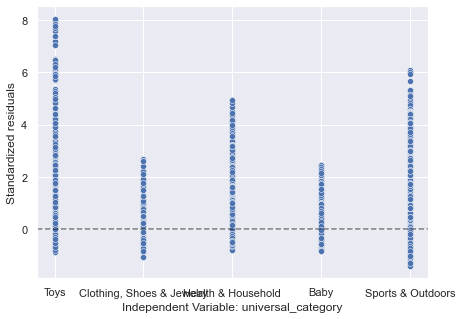

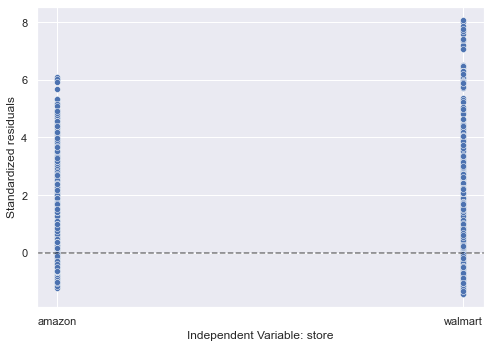

In [59]:

plt.figure(figsize=(7,5))
sns.scatterplot(x=df['universal_category'], y=standardize(residuals))
plt.xlabel(f'Independent Variable: universal_category')
plt.ylabel('Standardized residuals')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x=df['store'], y=standardize(residuals))
plt.xlabel(f'Independent Variable: store')
plt.ylabel('Standardized residuals')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()

**Linearity**: The relationship between the independent variables and the response appears somewhat linear but not completely, since the residuals are mostly clustered around the line $y = 0$ as the independent variable changes, but there is some bias in the residuals where the positive residuals tend to be further from $y=0$ than the negative residuals. Based off of the plots above, it is difficult to say if this should satisfy the linearity assumption, but I think it can pass the linearity assumption.

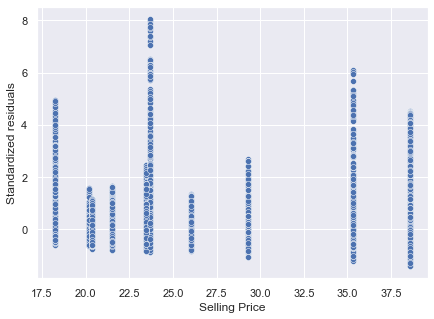

In [60]:
plt.figure(figsize=(7,5))

sns.scatterplot(x=model.fittedvalues, y=standardize(residuals))
plt.xlabel('Selling Price')
plt.ylabel('Standardized residuals');

**Identical errors / homoscedasticity:** The plot of the residuals against the response variable $y$ shows a pretty random pattern clustered around $y=0$, but there is some bias in the residuals where the positive residuals tend to be further from $y=0$ than the negative residuals. There is also some degree of visible fanning out as price increases. Overall, these are look like potentially significant enough effects to violate the identical errors assumption.

In the plot of the residuals against the independent variable "Universal Category", there is potential heteroscedasticity in both datasets since in the "Sports $\&$ Outdoors" and "Toys" categories of the walmart dataset, there is some visual indication of increased variance. The same is true in the "Health $\&$ Household" and "Sports $\&$ Outdoors" categories of the amazon dataset. This might also violate the identical errors assumption.

- $\text{Var}(\epsilon_i) = \sigma^2 \quad \forall i$.

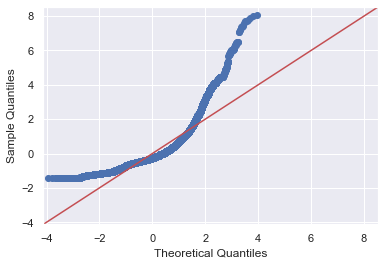

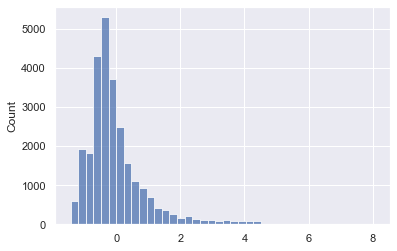

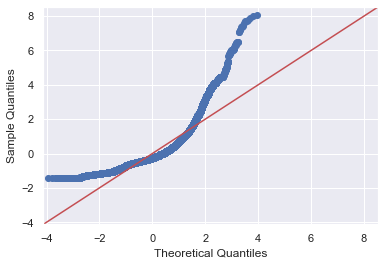

In [69]:
#fig, axs = plt.subplots(2, 1, figsize=(8, 8))

sns.histplot(standardize(residuals), bins=40)
sm.qqplot(standardize(residuals), line='45')

In [70]:
shapiro = stats.shapiro(standardize(residuals))
print(f'Normality p-value:{shapiro.pvalue}')


Normality p-value:0.0


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Normality**: Visually, it it does not look like the normality assumption is met. Using the Shapiro-Wilk test to obtain a more quantitative result to base a decision off of, we get an extremely low p-value for both datasets ($\approx 1.07 \times 10^{-86}$ for walmart, and $\approx 1.07 \times 10^{-69}$ for amazon) that would satisfy being below any reasonable value of $\alpha$ for which we would base the hypothesis test. 

$$
\color{red}{\text{Try np.log(response) in regression models}}
$$

Text(0, 0.5, 'ACF')

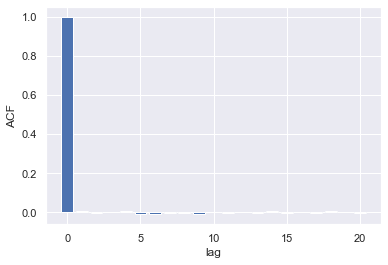

In [72]:
lags = 20

plt.bar(range(lags+1), acf(residuals, nlags=lags))
plt.xlabel('lag'); plt.ylabel('ACF')


**Independence:** The ACF is is very close to $0$ even at one lag, indicating that the independence of the residuals assumption is satisfied for both datasets.
 
- $\epsilon_1, \epsilon_2, \dots, \epsilon_n \quad$ are dependent, because $y_{i+k}$ with lag $k$ is not influenced by the value of $y_i, \forall k \leq 20$.


**Completeness:** There may be variables which influence the response $y$ are not included in the covariates. There is no way to know if this is the case, but we are considring a lot of covariates which provide insight into this, so we will assume completeness.